### Algoritmo Genético para resolver o problema das N-Rainhas
Carlos Bravo e Markson Arguello

#### Modelagem do tabuleiro

In [1]:
from random import randint, choice, random
import matplotlib.pyplot as plt
from functools import cmp_to_key

In [2]:
def tabuleiro(tamanho, quantidade):
  return [[randint(0,tamanho-1) for j in range(tamanho)] for i in range(quantidade)]

In [3]:
def moveRainha(l,i):
  return [l[:i] + [k] + l[i+1:] for k in range(0,len(l)) if k != l[i]]

def todosVizinhos(T):
  vizinhos = []
  for i in range(len(T)):
    vizinhos.extend(moveRainha(T,i))
  return vizinhos

In [4]:
def umVizinho(T):
  return choice(todosVizinhos(T))

In [5]:
def numeroAtaques(T):
  ataques = 0
  for i in range(len(T)):
    for j in range(i+1, len(T)):
      if(T[i] == T[j]): ataques += 1
      if(abs(T[i] - T[j]) == abs(i - j)): ataques += 1
  return ataques

#### Algoritmo Genético

In [6]:
def gera_populacao(n):
  populacao = tabuleiro(tamanho_tabuleiro, n)
  return populacao

In [7]:
def adaptacao(cromossomo):
  maximo_ataques = tamanho_tabuleiro * (tamanho_tabuleiro - 1) / 2
  return (maximo_ataques - numeroAtaques(cromossomo)) / maximo_ataques

In [8]:
def roleta(populacao):
  soma = sum([adaptacao(cromossomo) for cromossomo in populacao])
  probabilidade = []
  for i in range(len(populacao)):
    probabilidade.append(adaptacao(populacao[i]) / soma)
    if i > 0:
      probabilidade[i] += probabilidade[i - 1]

  return probabilidade

In [9]:
def selecao(populacao):
  probabilidade = roleta(populacao)
  selecionados = []
  for i in range(len(populacao)):
    r = random()
    for j in range(len(probabilidade)):
      if r <= probabilidade[j]:
        selecionados.append(populacao[j])
        break
  return selecionados

In [10]:
def crossover(pai, mae):
  corte = randint(1, tamanho_tabuleiro - 1)
  filho1 = pai[:corte] + mae[corte:]
  filho2 = mae[:corte] + pai[corte:]
  return filho1, filho2

In [11]:
def mutacao(cromossomo):
  posicao = randint(0, tamanho_tabuleiro - 1)
  cromossomo = cromossomo[:posicao] + [randint(0, tamanho_tabuleiro - 1)] + cromossomo[posicao + 1:]
  return cromossomo

In [12]:
def seleciona_elite(populacao):
  populacao = sorted(populacao, key = adaptacao, reverse = True)
  return populacao[0]

In [57]:
def algoritmoGenetico(tamanho_populacao, n_geracoes, prob_crossover, prob_mutacao, elitismo = False):
  populacao = gera_populacao(tamanho_populacao) # Gera a população inicial
  melhores_individuos = []
  medias_adaptacao = []
  for i in range(n_geracoes):
    populacao_intermediaria = selecao(populacao) # Seleciona os indivíduos da população
    elite = seleciona_elite(populacao)

    medias_adaptacao.append(sum([adaptacao(cromossomo) for cromossomo in populacao_intermediaria]) / len(populacao_intermediaria))
    melhores_individuos.append(elite)

    populacao = []
    for j in range(0, len(populacao_intermediaria) - 1, 2): # Realiza o crossover
      if random() < prob_crossover: 
        filho1, filho2 = crossover(populacao_intermediaria[j], populacao_intermediaria[j + 1])
        populacao.append(filho1)
        populacao.append(filho2)
      else:
        populacao.append(populacao_intermediaria[j])
        populacao.append(populacao_intermediaria[j + 1])
    
    if len(populacao_intermediaria) % 2 == 1: # Caso o número de indivíduos seja ímpar
      populacao.append(populacao_intermediaria[-1])

    for j in range(len(populacao)): # Realiza a mutação
      if random() < prob_mutacao:
        populacao[j] = mutacao(populacao[j])

    if elitismo: 
      populacao = populacao[:tamanho_populacao - 1] + [elite]


  
  return melhores_individuos, medias_adaptacao

#### Impressão de resultado

In [28]:
# Imprime o resultado de uma execução do algoritmo genético colocando um gráfico ao lado da outro
def imprime_resultados(execucao):
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))

  melhores_individuos, medias_adaptacao = execucao
  axs[0].plot(medias_adaptacao)
  axs[0].set_xlabel('Geração')
  axs[0].set_ylabel('Média de aptidão')
  axs[0].title.set_text('Média de aptidão por geração')


  axs[1].plot([adaptacao(individuo) for individuo in melhores_individuos])
  axs[1].set_xlabel('Geração')
  axs[1].set_ylabel('Aptidão melhor indivíduo')
  axs[1].title.set_text('Aptidão do melhor indivíduo por geração')

  plt.show()

  # Print do melhor indivíduo
  print('Melhor indivíduo: ', melhores_individuos[-1])
  print('Aptidão: ', adaptacao(melhores_individuos[-1]))

In [29]:
# Função que compara execuções, coloca o que teve a melhor aptidão no final primeiro, caso tenha a mesma aptidão, coloca o que teve a melhor média de aptidão
def compare(x, y):
  if x['melhor'] > y['melhor']:
      return 1
  elif x['melhor'] < y['melhor']:
    return -1
  else:
    if x['media'] > y['media']:
      return 1
    elif x['media'] < y['media']:
      return -1
    else:
      return 0
    

#### Compara hiper parâmetros

Função para fazer a combinação dos valores dos parâmetros e retornar uma lista, contendo a combinação dos parâmetros de cada execução, a média e a melhor aptidão. A lista é ordenada, as melhores execuções vem primeiro.

In [43]:
def compara_hiperparametros(tamanho_populacao, n_geracoes, prob_crossover, prob_mutacao, elitismo = [True, False], n_repeticoes = 10):
  execucoes = []
  for tamanho_populacao_atual in tamanho_populacao:
    for n_geracoes_atual in n_geracoes: 
      for prob_mutacao_atual in prob_mutacao: 
        for prob_crossover_atual in prob_crossover: 
          for elitismo_atual in elitismo: 
            media = 0
            melhor = 0
            for i in range(n_repeticoes): # 10
              _, medias_adaptacao = algoritmoGenetico(tamanho_populacao_atual, n_geracoes_atual, prob_crossover_atual, prob_mutacao_atual, elitismo_atual)
              media += medias_adaptacao[-1]
              melhor = max(melhor, medias_adaptacao[-1])

            media /= n_repeticoes
            execucoes.append({
                'tamanho_populacao': tamanho_populacao_atual,
                'n_geracoes': n_geracoes_atual,
                'prob_crossover': prob_crossover_atual,
                'prob_mutacao': prob_mutacao_atual,
                'elitismo': elitismo_atual,
                'media': media,
                'melhor': melhor
            })

          if len(elitismo) == 2: # Caso o elitismo seja uma lista de [True, False]
            comparacao = compare(execucoes[-1], execucoes[-2]) # Compara a execução com elitismo e sem elitismo
            if comparacao == 1: # Se a execução com elitismo for melhor, remove a execução sem elitismo
              execucoes.pop(-2)
            elif comparacao == -1: # Se a execução sem elitismo for melhor, remove a execução com elitismo
              execucoes.pop(-1)
            else: # Se as duas execuções tiverem o mesmo resultado, remove a execução sem elitismo
              execucoes.pop(-2)
  
  execucoes = execucoes = sorted(execucoes, key=cmp_to_key(compare), reverse=True)
  return execucoes
    

In [27]:
tamanhos = [8, 16, 32]
for tamanho in tamanhos:
  tamanho_tabuleiro = tamanho
  execucoes = compara_hiperparametros(
    tamanho_populacao=[10, 100, 500],
    n_geracoes=[25, 50, 100],
    prob_crossover=[0.7, 0.75, 0.8],
    prob_mutacao=[0.01, 0.03, 0.05],
    elitismo = [True, False],
    n_repeticoes = 10)
  
  file = open('execucoes_' + str(tamanho) + '.txt', 'w')
  file.write(str(execucoes))
  file.close()

In [33]:
# Dados os hipermarametros
def media_parametros_execucoes(execucoes):
  media = {
      'tamanho_populacao': 0,
      'n_geracoes': 0,
      'prob_crossover': 0,
      'prob_mutacao':0,
  }

  for execucao in execucoes:
    for key in media:
      media[key] += execucao[key]
    
  for key in media:
    media[key] /= len(execucoes)
    print(key, media[key])
  

In [61]:
print('========Média de melhores execuções tamanho 8========')
media_parametros_execucoes(melhores_tamanho_8)
print()
print('========Média de piores execuções tamanho 8========')
media_parametros_execucoes(piores_tamanho_8)


========Média de melhores execuções tamanho 8========
tamanho_populacao 82.0
n_geracoes 90.0
prob_crossover 0.7300000000000001
prob_mutacao 0.026000000000000002

========Média de piores execuções tamanho 8========
tamanho_populacao 500.0
n_geracoes 25.0
prob_crossover 0.75
prob_mutacao 0.033999999999999996


In [62]:
print('========Média de melhores execuções tamanho 16========')
media_parametros_execucoes(melhores_tamanho_16)
print()
print('========Média de piores execuções tamanho 16========')
media_parametros_execucoes(piores_tamanho_16)

========Média de melhores execuções tamanho 16========
tamanho_populacao 28.0
n_geracoes 90.0
prob_crossover 0.76
prob_mutacao 0.030000000000000006

========Média de piores execuções tamanho 16========
tamanho_populacao 500.0
n_geracoes 25.0
prob_crossover 0.7799999999999999
prob_mutacao 0.026000000000000002


#### Tabuleiro de Tamanho 32
##### Com elitismo

In [45]:
tamanho_tabuleiro = 32
execucoes = compara_hiperparametros(
    tamanho_populacao=[55],
    n_geracoes=[100],
    prob_crossover=[0.75],
    prob_mutacao=[0.03],
    elitismo = [True],
    n_repeticoes = 10)

In [46]:
execucoes

[{'tamanho_populacao': 55,
  'n_geracoes': 100,
  'prob_crossover': 0.75,
  'prob_mutacao': 0.03,
  'elitismo': True,
  'media': 0.9591642228739005,
  'melhor': 0.9659824046920824}]

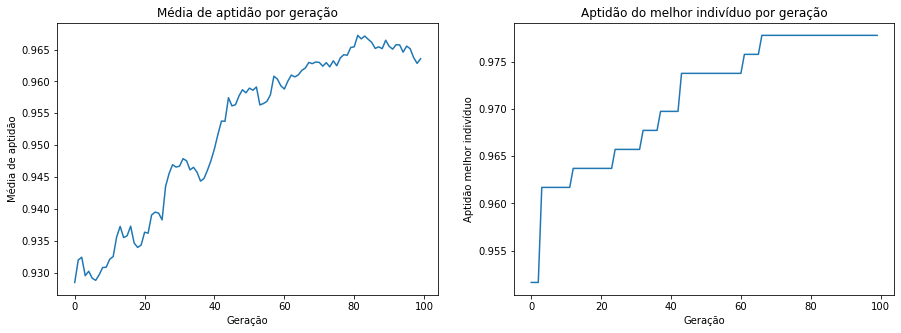

Melhor indivíduo:  [18, 0, 12, 24, 4, 29, 19, 14, 27, 11, 26, 6, 3, 21, 3, 1, 22, 31, 5, 11, 25, 30, 21, 13, 7, 15, 10, 2, 31, 17, 23, 8]
Aptidão:  0.9778225806451613


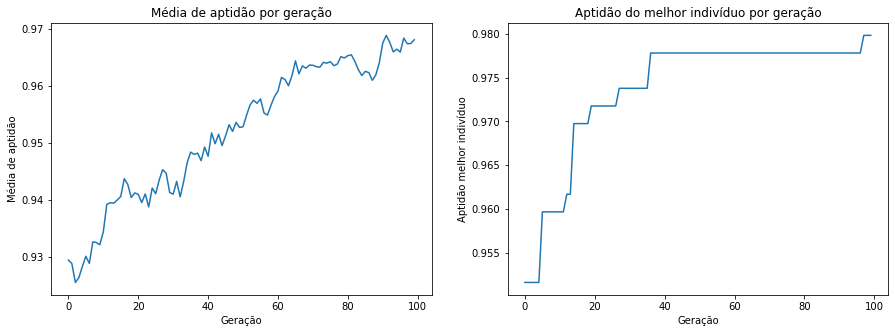

Melhor indivíduo:  [16, 6, 12, 22, 2, 23, 12, 29, 15, 1, 21, 8, 26, 30, 3, 24, 19, 20, 9, 7, 29, 25, 2, 7, 18, 3, 22, 0, 27, 11, 17, 10]
Aptidão:  0.9798387096774194


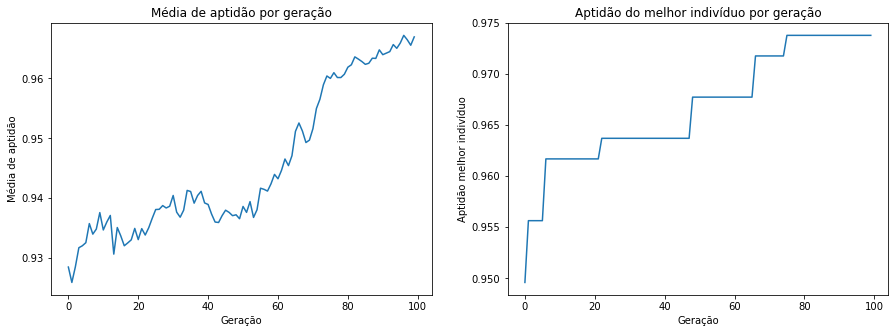

Melhor indivíduo:  [22, 7, 1, 3, 25, 14, 30, 8, 11, 16, 2, 5, 20, 23, 9, 26, 31, 1, 31, 12, 17, 7, 5, 28, 28, 15, 15, 27, 19, 26, 4, 29]
Aptidão:  0.9737903225806451


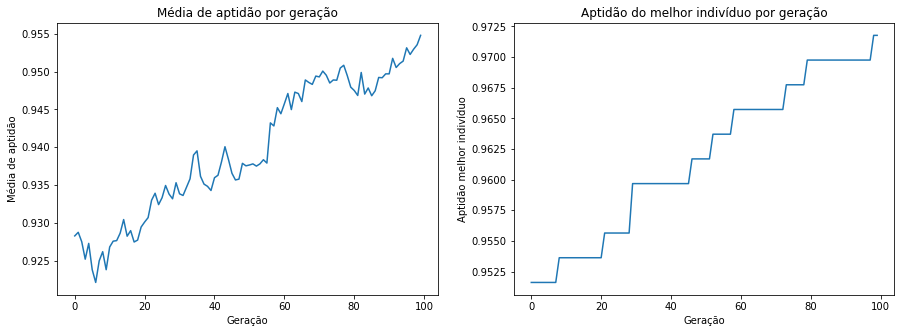

Melhor indivíduo:  [9, 21, 12, 21, 6, 23, 14, 5, 0, 18, 1, 22, 19, 28, 3, 15, 22, 31, 29, 6, 2, 9, 13, 20, 20, 17, 11, 2, 8, 27, 24, 26]
Aptidão:  0.9717741935483871


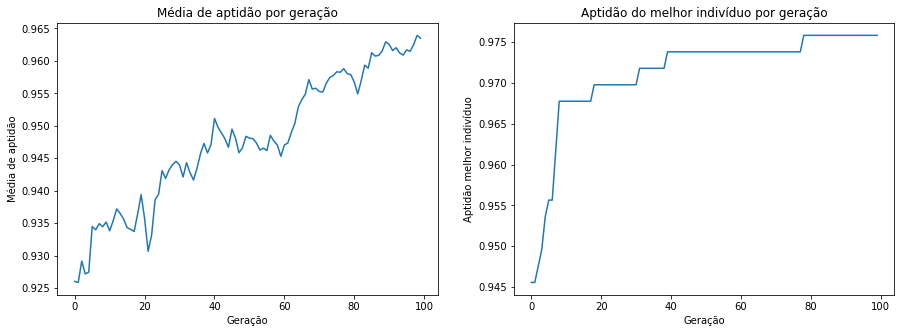

Melhor indivíduo:  [4, 20, 16, 8, 15, 29, 2, 6, 9, 19, 25, 1, 14, 30, 18, 10, 0, 3, 11, 17, 27, 6, 22, 7, 26, 24, 5, 12, 10, 25, 16, 31]
Aptidão:  0.9758064516129032


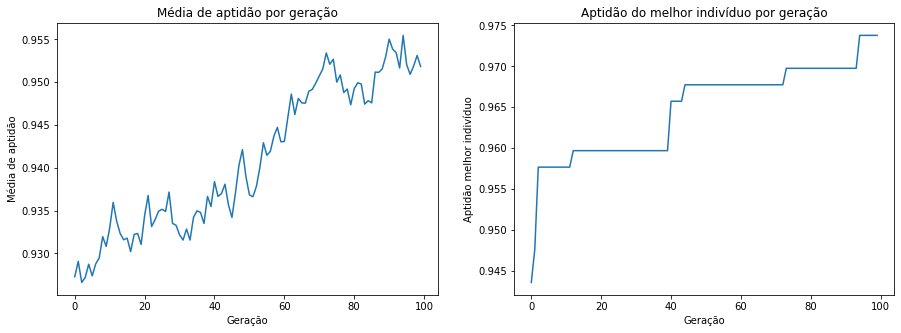

Melhor indivíduo:  [24, 13, 21, 3, 5, 25, 14, 4, 18, 10, 2, 17, 8, 3, 28, 26, 22, 20, 23, 2, 14, 31, 9, 7, 1, 11, 28, 12, 17, 22, 5, 19]
Aptidão:  0.9737903225806451


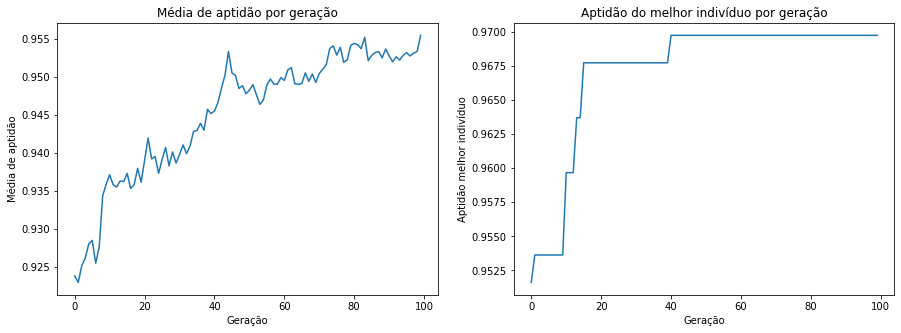

Melhor indivíduo:  [8, 14, 7, 2, 9, 23, 16, 19, 27, 3, 24, 6, 9, 15, 30, 4, 20, 25, 16, 31, 11, 6, 10, 15, 21, 29, 22, 24, 28, 1, 0, 12]
Aptidão:  0.969758064516129


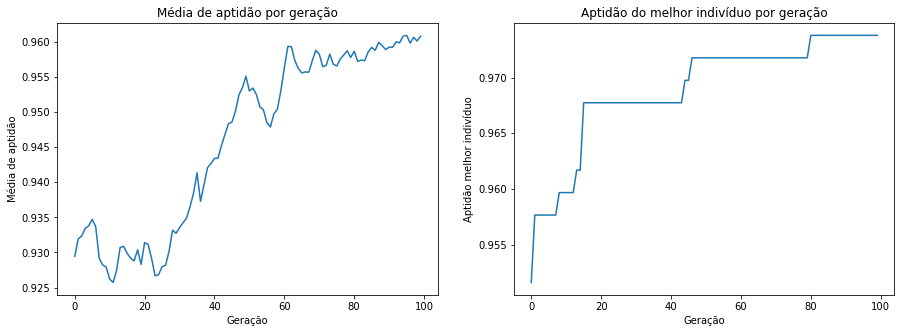

Melhor indivíduo:  [1, 29, 16, 21, 28, 11, 14, 19, 25, 30, 17, 10, 22, 0, 19, 13, 6, 20, 23, 19, 24, 8, 31, 5, 26, 0, 9, 12, 31, 20, 24, 15]
Aptidão:  0.9737903225806451


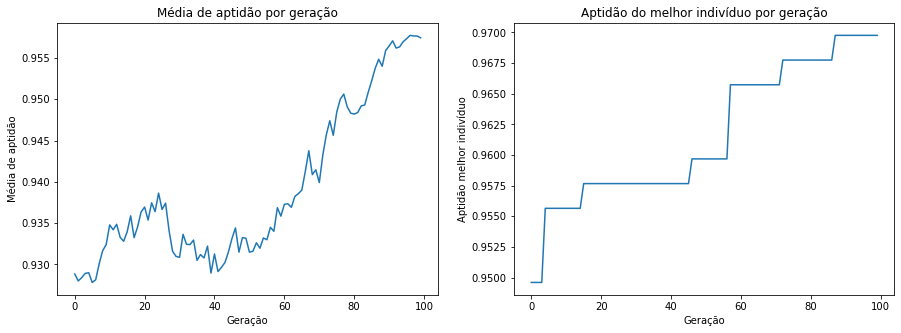

Melhor indivíduo:  [13, 29, 2, 30, 15, 13, 16, 19, 30, 25, 31, 16, 27, 4, 31, 12, 5, 19, 1, 28, 26, 14, 1, 21, 4, 7, 22, 22, 12, 27, 20, 28]
Aptidão:  0.969758064516129


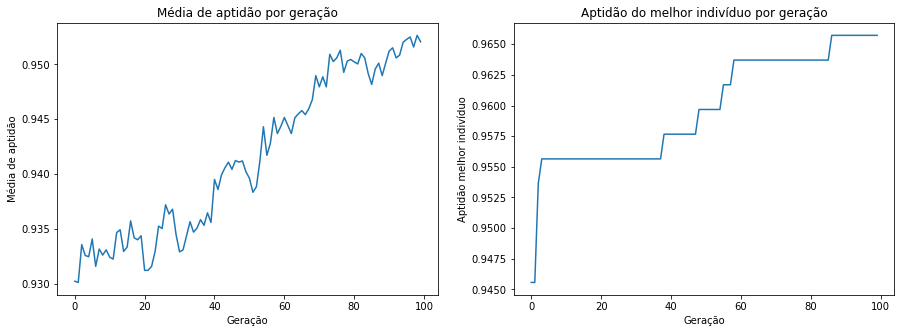

Melhor indivíduo:  [31, 5, 20, 15, 19, 19, 6, 25, 0, 12, 16, 8, 3, 18, 15, 28, 24, 26, 12, 9, 22, 2, 5, 30, 30, 9, 21, 7, 27, 23, 16, 16]
Aptidão:  0.9657258064516129


In [70]:
tamanho_tabuleiro = 32
execucoes = []
n_repeticoes = 10

for i in range(n_repeticoes):
    execucoes.append(algoritmoGenetico(tamanho_populacao=55, n_geracoes=100, prob_crossover=0.75, prob_mutacao=0.03, elitismo=True))
    imprime_resultados(execucoes[-1])


#### Tabuleiro de Tamanho 32
##### Sem elitismo

In [75]:
tamanho_tabuleiro = 32
execucoes = compara_hiperparametros(
    tamanho_populacao=[55],
    n_geracoes=[100],
    prob_crossover=[0.75],
    prob_mutacao=[0.03],
    elitismo = [False],
    n_repeticoes = 10)

In [76]:
execucoes

[{'tamanho_populacao': 55,
  'n_geracoes': 100,
  'prob_crossover': 0.75,
  'prob_mutacao': 0.03,
  'elitismo': False,
  'media': 0.9295564516129028,
  'melhor': 0.9434750733137832}]

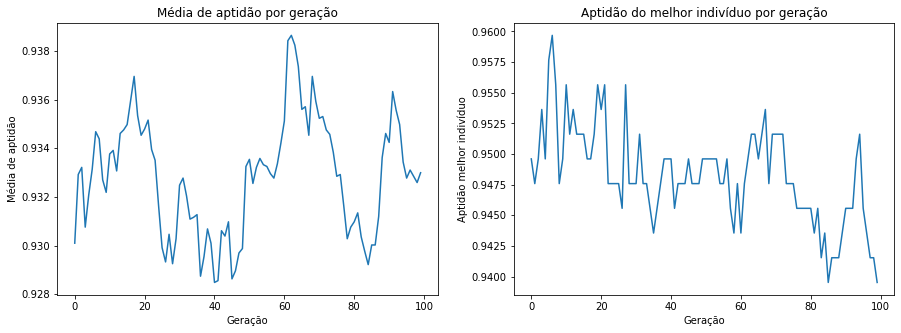

Melhor indivíduo:  [21, 13, 2, 27, 2, 22, 16, 3, 26, 5, 0, 23, 25, 30, 27, 31, 20, 0, 10, 28, 2, 13, 25, 14, 27, 7, 11, 1, 29, 9, 3, 11]
Aptidão:  0.9395161290322581


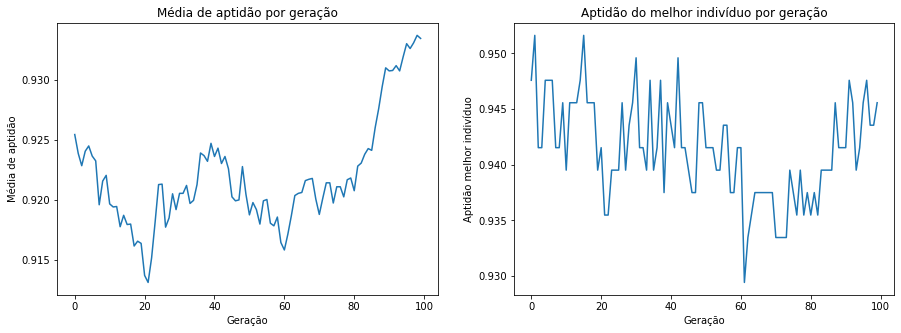

Melhor indivíduo:  [25, 18, 31, 22, 11, 21, 15, 25, 4, 17, 31, 3, 5, 22, 10, 26, 5, 14, 1, 25, 22, 15, 6, 8, 5, 12, 11, 16, 21, 13, 28, 19]
Aptidão:  0.9455645161290323


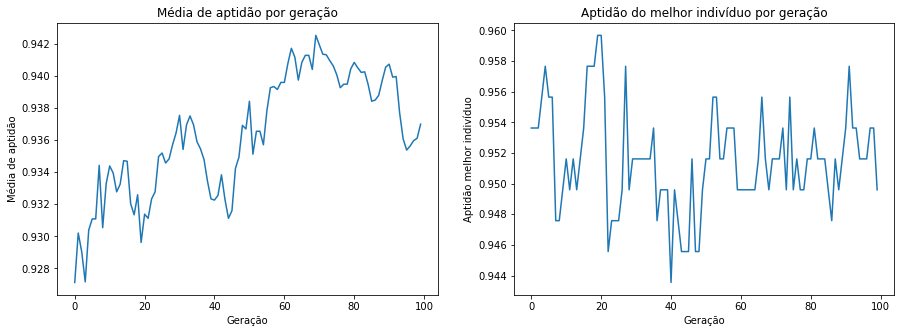

Melhor indivíduo:  [29, 25, 19, 24, 0, 12, 12, 17, 30, 9, 11, 28, 0, 15, 23, 29, 0, 23, 28, 24, 31, 27, 20, 22, 12, 16, 9, 10, 4, 1, 31, 28]
Aptidão:  0.9495967741935484


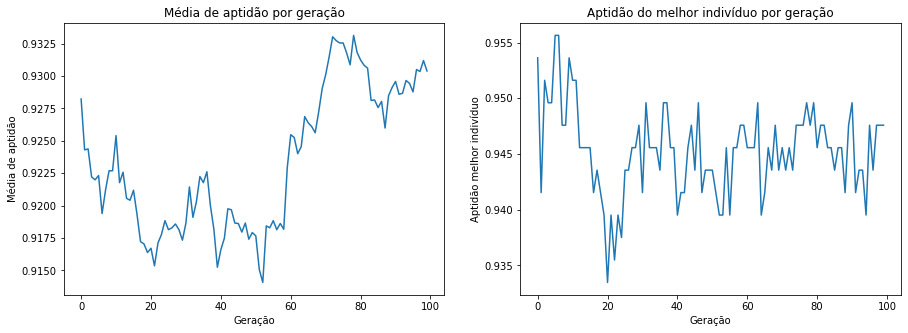

Melhor indivíduo:  [20, 3, 11, 21, 4, 5, 23, 13, 6, 10, 2, 20, 0, 10, 3, 26, 29, 16, 22, 20, 22, 12, 0, 2, 16, 0, 4, 30, 23, 31, 14, 18]
Aptidão:  0.9475806451612904


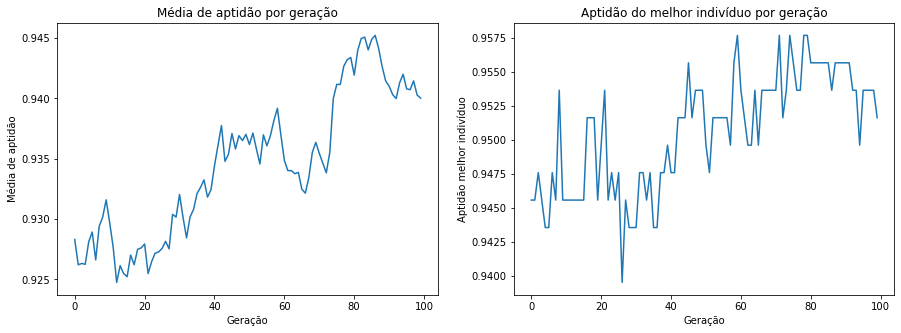

Melhor indivíduo:  [14, 2, 22, 21, 26, 3, 17, 10, 8, 31, 6, 4, 7, 26, 26, 17, 31, 9, 5, 1, 1, 0, 27, 15, 30, 13, 3, 10, 24, 25, 13, 24]
Aptidão:  0.9516129032258065


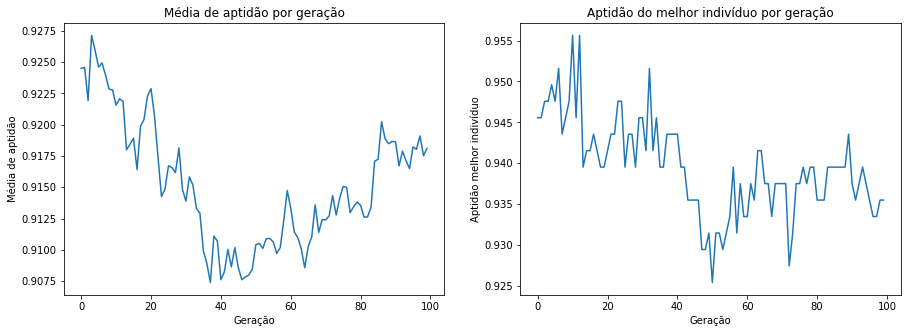

Melhor indivíduo:  [21, 9, 21, 30, 1, 24, 6, 25, 24, 26, 28, 24, 29, 4, 13, 22, 16, 20, 5, 0, 31, 16, 4, 27, 10, 27, 6, 12, 1, 12, 13, 31]
Aptidão:  0.9354838709677419


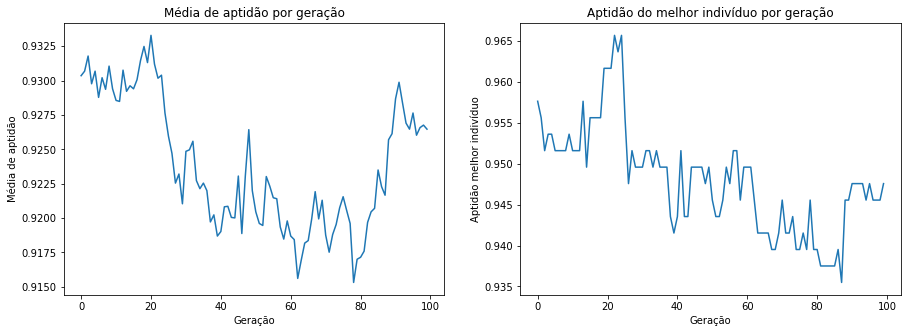

Melhor indivíduo:  [6, 0, 31, 4, 2, 27, 30, 10, 17, 0, 1, 21, 30, 8, 9, 26, 1, 5, 1, 14, 18, 2, 9, 25, 10, 19, 16, 20, 17, 12, 28, 19]
Aptidão:  0.9475806451612904


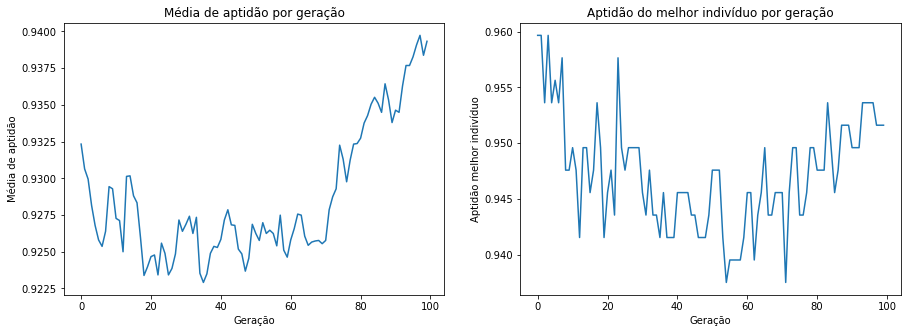

Melhor indivíduo:  [7, 30, 31, 19, 15, 3, 18, 29, 2, 1, 29, 5, 26, 22, 17, 25, 2, 11, 14, 9, 12, 27, 23, 31, 6, 8, 12, 10, 4, 10, 13, 15]
Aptidão:  0.9516129032258065


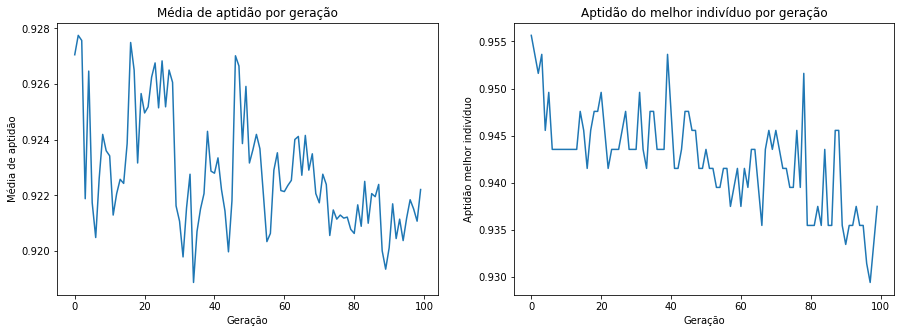

Melhor indivíduo:  [13, 20, 0, 15, 16, 12, 29, 19, 27, 24, 28, 29, 13, 21, 24, 14, 3, 1, 0, 7, 17, 28, 12, 23, 3, 28, 18, 2, 27, 21, 20, 22]
Aptidão:  0.9375


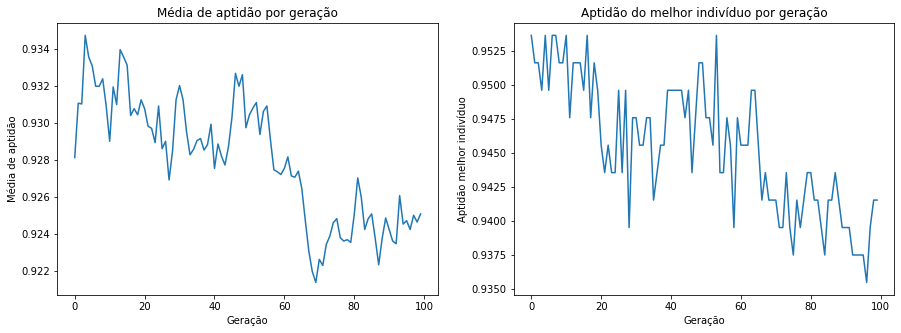

Melhor indivíduo:  [31, 16, 14, 23, 10, 23, 24, 15, 7, 23, 20, 26, 30, 17, 10, 1, 6, 5, 5, 16, 12, 4, 25, 21, 15, 22, 3, 26, 22, 2, 3, 2]
Aptidão:  0.9415322580645161


In [71]:
tamanho_tabuleiro = 32
execucoes = []
n_repeticoes = 10

for i in range(n_repeticoes):
    execucoes.append(algoritmoGenetico(tamanho_populacao=55, n_geracoes=100, prob_crossover=0.75, prob_mutacao=0.03, elitismo=False))
    imprime_resultados(execucoes[-1])